# From edges to lane markings
## Hough transform and evaluation metric

In the Edge Detection notebook we saw the nitty gritty details of how edges are detected. These include the edges of trees, cars, buildings, the dashboard. We can filter these edges for stright lines with the Hough tranform. Although other stright lines in the image will also pass this filter (building edges, car bumper and siding, poles, fences), we can set a modest goal to enrich the image for lane markings. 

Tuning the parameters depends greatly on the evaluation metrix. Several recent papers illustrate the heuristics of this process. In [conference proceedings](https://ieeexplore.ieee.org/document/6728473) from International IEEE Conference on Intelligent Transportation Systems (ITSC 2013), three researchers from Honda Research Institute Europe GmbH, Max Planck Institute for Intelligent Systems in Tübingen, both in Germany developed a metric to address the challenges of urban roads, which are less ideal than rural and highway settings.



In [0]:
!pip install bezier
import bezier
import cv2
import numpy as np
import json
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import glob

In [0]:
import glob

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# Import Data


In [0]:
wildcard_path = '/content/drive/My Drive/ece1512/\
homework/3/bdd100k/images/10k/train/*.jpg'
files = set([f.split('/')[-1] for f in glob.glob(wildcard_path)])
fname = '/content/drive/My Drive/ece1512/homework/3/bdd100k/\
labels/bdd100k_labels_images_train.json'
with open(fname) as f:
    data100k = json.load(f)[:1000] # test batch
data10k = [d for d in data100k if d['name'] in files]

Text(0.5, 1.0, 'Original image, gray scale')

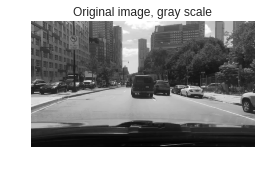

In [267]:
i=12
example = data10k[i]
image_dir='/content/drive/My Drive/ece1512/homework/3/bdd100k/images/10k/train/'
img = cv2.imread(image_dir+example['name'])
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
smooth = gaussian_filter(gray,sigma=1.7)
fig = plt.figure(figsize=(4,4))
plt.imshow(smooth,cmap='gray')
plt.axis('off')
plt.title('Original image, gray scale')


# Canny edge detection
Here we use the OpenCV implementation of Canny edge detection.   See the [documentation.](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_canny/py_canny.html?highlight=canny)
- `threshold1` and `threshold2` are the low and high values for the double threshold hydteresis are given in 8 bit intensity values $\in [0,255]$  
- The param `apertureSize` refers to the size of the Sobel operator  
- `L2gradient`: the gradient can be L1 (`L2gradient=False`) or L2 (`L2gradient=True`)

We can first pick an image and hand tune the Canny hi and low thresholds to recognize the images. The Hough transform can only detect lines where there are edges. 

Text(0.5, 1.0, 'Canny Edge detection')

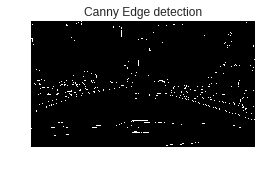

In [269]:
fig = plt.figure(figsize=(4,4))
edges = cv2.Canny(smooth,threshold1=20, 
                  threshold2=150,
                  apertureSize = 3,
                  L2gradient=False) 
plt.imshow(edges,cmap='gray')
plt.axis('off')
plt.title('Canny Edge detection')

# Hough transform
The Hough transform considers pairs of pixels, and draws a line between them. It then keeps track of how frequently this type of line appears in an accumulator. The transform parametrizes lines with a radius and angle instead of a slope and intercept.   The documentaiton explains that  
1. `rho` and  `theta` are the granularity of the bin sizes in pixels and radians, respectively.  
2.  `threshold` is a cut off for the accumulator.  `Only those lines are returned that get enough votes`   
3. `minLineLength: Line segments shorter than that are rejected`` 
4. `maxLineGap:` points on the same line are not linked if they are separated more than `maxLineGap` pixels

9


Text(0.5, 1.0, 'Lines detection with the Hough Transform')

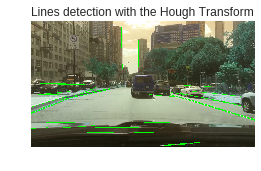

In [298]:
lines = cv2.HoughLinesP(image=edges,
                        rho=1, 
                        theta=np.pi/180.,
                        threshold=160,
                        minLineLength=75,
                        maxLineGap=60 
                       )# returns cmin,rmin,cmax,rmax. 
assert lines is not None

print(len(lines))
for line in lines:
  for x1,y1,x2,y2 in line:
      cv2.line(img,(x1,y1),(x2,y2),(0,255,0),2)
fig = plt.figure(figsize=(4,4))
plt.imshow(img)
plt.axis('off')
plt.title('Lines detection with the Hough Transform')

In [0]:
import pandas as pd


Text(0, 0.5, 'Number of lines')

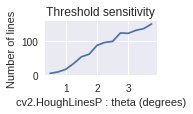

In [301]:
n_lines=[]
rhos = np.arange(0.5,4,0.25)
for rho in rhos:
  lines = cv2.HoughLinesP(image=edges,
                        rho=rho, 
                        theta=np.pi/180.,
                        threshold=150,
                        minLineLength=75,
                        maxLineGap=50 
                       )
  if lines is None: lines=[]
  n_lines.append(lines)
sr = pd.Series([len(lines) for lines in n_lines])
sr.index = rhos

plt.figure(figsize=(2,1))
sr.plot(title='Threshold sensitivity')
plt.xlabel('cv2.HoughLinesP : theta (degrees)')
plt.ylabel('Number of lines')

Text(0, 0.5, 'Number of lines')

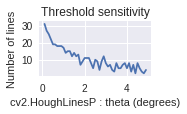

In [279]:
n_lines=[]
thetas = np.arange(0.1,5,0.1)
for theta in thetas:
  lines = cv2.HoughLinesP(image=edges,
                        rho=1, 
                        theta=theta*np.pi/180.,
                        threshold=150,
                        minLineLength=75,
                        maxLineGap=50 
                       )
  if lines is None: lines=[]
  n_lines.append(lines)
sr = pd.Series([len(lines) for lines in n_lines])
sr.index = thetas

plt.figure(figsize=(2,1))
sr.plot(title='Threshold sensitivity')
plt.xlabel('cv2.HoughLinesP : theta (degrees)')
plt.ylabel('Number of lines')

Text(0, 0.5, 'Number of lines')

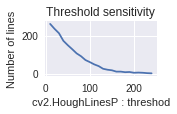

In [276]:
n_lines=[]
thresholds = np.arange(10,250,10)
for threshold in thresholds:
  lines = cv2.HoughLinesP(image=edges,
                        rho=1, 
                        theta=np.pi/180.,
                        threshold=threshold,
                        minLineLength=75,
                        maxLineGap=50 
                       )
  if lines is None: lines=[]
  n_lines.append(lines)
sr = pd.Series([len(lines) for lines in n_lines])
sr.index = thresholds


plt.figure(figsize=(2,1))
sr.plot(title='Threshold sensitivity')
plt.xlabel('cv2.HoughLinesP : threshod')
plt.ylabel('Number of lines')

  
  

Text(0, 0.5, 'Number of lines')

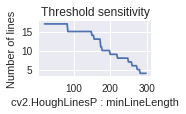

In [306]:
n_lines=[]
minLineLengths = np.arange(20,300,2)
for minLineLength in minLineLengths:
  lines = cv2.HoughLinesP(image=edges,
                        rho=1, 
                        theta=np.pi/180.,
                        threshold=150,
                        minLineLength=minLineLength,
                        maxLineGap=50 
                       )
  if lines is None: lines=[]
  n_lines.append(lines)
sr = pd.Series([len(lines) for lines in n_lines])
sr.index = minLineLengths

plt.figure(figsize=(2,1))
sr.plot(title='Threshold sensitivity')
plt.xlabel('cv2.HoughLinesP : minLineLength')
plt.ylabel('Number of lines')

Text(0, 0.5, 'Number of lines')

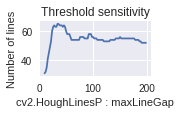

In [307]:
n_lines=[]
maxLineGaps = np.arange(10,200,2)
for maxLineGap in maxLineGaps:
  lines = cv2.HoughLinesP(image=edges,
                        rho=1, 
                        theta=np.pi/180.,
                        threshold=100,
                        minLineLength=75,
                        maxLineGap=maxLineGap 
                       )
  if lines is None: lines=[]
  n_lines.append(lines)
sr = pd.Series([len(lines) for lines in n_lines])
sr.index = maxLineGaps

plt.figure(figsize=(2,1))
sr.plot(title='Threshold sensitivity')
plt.xlabel('cv2.HoughLinesP : maxLineGap')
plt.ylabel('Number of lines')

These threshold sensitivities are just looking at the predicted number of lines, because we don't have a method to compare to the ground truth (yet). However, they do help guide the parameter space that we can search once we have a method. In summery, the number of predicted lines:  
  1. increases with `rho`. Suitable value 1-2  
  2. decreases with `theta`. Suitable value 1-2 degrees  
  3. decreases with `threshold`. Suitable value 100-200  
  4. decreases with `minLineLength`. Suitable value < 200  
  5. increases then plateaus with maxLineGap. Suitable value 10-100  


# Ground truth using Bézier curves
The number of lines returned depends on all parameters at once. What I would really like to know is what combination of parameters yields a detection of the true line, ie when it appears. To do this, we need some way of cmoparing the ground truth to the lines. We can draw a box (or little sub boxes) around the lines and then look at the overlap.

The lane markings are annotated with vertices. We can interpolate between these annotations with  Bezier curves. Since the lane markings are smooth in the field of view, we use `degree=4`. This yields points (`100` points should suffice), out of which we can make a box or sub-boxes for each lane marking.

In [0]:
from scipy.spatial import distance

def comp_bezier_pts(nodes,degree=4,num=100):
  curve = bezier.Curve(nodes, degree=degree)
  s = np.linspace(0,1,num) 
  pts = curve.evaluate_multi(s)
  return(pts)

def rolling_window(a, window, step_size):
  '''
  credit: https://gist.github.com/codehacken/708f19ae746784cef6e68b037af65788
  '''
  shape = a.shape[:-1] + (a.shape[-1] - window + 1 - step_size, window)
  strides = a.strides + (a.strides[-1] * step_size,)
  rw = np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)
  return(rw)
  
def sub_boxes_from_pts(pts,box_diag=150,method=None):
  '''
  param box_diag # 50 - 200?
  '''
  boxes=[]
   
  if method is None:
    n_boxes = np.round(np.linalg.norm(pts.max(1)-pts.min(1)) / box_diag
                      ).astype(int)
    n_boxes = min(n_boxes,pts.shape[1]) # in case n_boxes > number of pts
    n_boxes = max(n_boxes,1)

    segments = np.array_split(pts.T,n_boxes)

  elif method == 'thick':
    
    pt_dist = distance.euclidean(pts[:,0],pts[:,1]) # 100 pts, want image extent
    window = np.round(box_diag / pt_dist).astype(int) # in pix on image, not pts
    c=rolling_window(pts[0], window=window, step_size=1)
    #assert np.isclose(c.max(),pts[0].max())
    #assert np.isclose(c.min(),pts[0].min())
    r=rolling_window(pts[1], window=window, step_size=1)
    #assert np.isclose(r.max(),pts[1].max())
    #assert np.isclose(r.min(),pts[1].min())
    M,N = c.shape
    segments = np.zeros((M,N,2))
    segments[:,:,0] = c
    segments[:,:,1] = r
    
  else:
    assert False
  
  for segment in segments:
    cmin,rmin = segment.min(0).astype(int)
    cmax,rmax = segment.max(0).astype(int)
    boxes.append([cmin,rmin,cmax,rmax])
    
  return(boxes)

def boxes_from_gtlanes(lanes,method=None,box_diag=150):
  '''
  param method: 'bezier' for piece wise
  param box_diag: size of subbozes
  '''
  boxes=[]
  assert method in [None, 'bezier']
  
  for lane in lanes:
    poly2d = lane['poly2d']
    assert len(poly2d) == 1, 'poly2d length is not one. parse it.'
    nodes = np.array(lane['poly2d'][0]['vertices']) # col,row

    if method is None:

      cmin,rmin = nodes.min(0)
      cmax,rmax = nodes.max(0)
      boxes.append([cmin,rmin,cmax,rmax])

    elif method == 'bezier':
      nodes = np.asfortranarray([nodes[:,0].tolist(),nodes[:,1].tolist()])
      pts = comp_bezier_pts(nodes)
      try:
        sub_boxes = sub_boxes_from_pts(pts,box_diag=box_diag,method='thick')
      except Exception as e:
        sub_boxes = sub_boxes_from_pts(pts,box_diag=box_diag)
        print(e,'. thick method failed for',lane)
      boxes.extend(sub_boxes)
    
    
  return(boxes)



In [0]:
r = np.arange(gray.shape[0])
c = np.arange(gray.shape[1])

def boxes_to_bool2d(boxes,r,c,method='add'):
  '''and method faster'''
  assert method in ['add','logical_or']
  bool2d_list = []
  bool2d = np.zeros((r.size,c.size)).astype(bool)
  
  for box in boxes:
    cmin,rmin,cmax,rmax = box

    rbool = np.logical_and(rmin < r,r < rmax ) # TODO: <, <=, etc
    cbool = np.logical_and(cmin < c,c < cmax )
    box2d = np.outer(rbool,cbool)
    if method == 'add':
      bool2d += box2d
    elif method == 'logical_or':
      bool2d_list.append(box2d)
    
    if method == 'logical_or':
    # https://stackoverflow.com/questions/20528328/
    #numpy-logical-or-for-more-than-two-arguments
      bool2d = np.logical_or.reduce(bool2d_list) 
      
  return(bool2d.astype(bool))

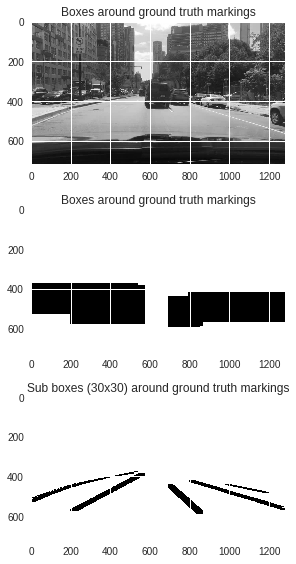

In [286]:
objects = example['labels']
lanes = [o for o in objects
            if 'poly2d' in o and o['category'][:4] == 'lane']

fig = plt.figure(figsize=(25,8))


plt.subplot(311)
plt.imshow(gray,cmap='gray')
plt.title('Boxes around ground truth markings')
#plt.axis('off')

plt.subplot(312)
gt_boxes = boxes_from_gtlanes(lanes)
gt_box_2d = boxes_to_bool2d(gt_boxes,r,c,method='add')
plt.imshow(gt_box_2d)
plt.title('Boxes around ground truth markings')

plt.subplot(313)
box_diag=30
gt_boxes = boxes_from_gtlanes(lanes,method='bezier',box_diag=box_diag)
gt_box_2d = boxes_to_bool2d(gt_boxes,r,c,method='add')
plt.imshow(gt_box_2d)
plt.title('Sub boxes (%ix%i) around ground truth markings' 
          % (box_diag,box_diag))
#plt.axis('off')

plt.tight_layout()


### Image-wide IoU
We can do the same with our predicted lines and then use an intersection over union (IoU) metric, image wide, to evaluate our prediction. I personally settled on this image wide IoU after many conversations with other ECE1512 students and research in the literature and existing code bases. An alternative method would need some sort of way to assign the pixels to a confusion matrix. However any method to assign true/false-positives-negatives seems to involve various heuristice, such as  
- how to pair up the predictions wtih the ground truth, since there are multiple lanes and predictions per image  
- the distance cutoffs of how close the prediction and ground truth need to be to assign as close/far  

For instance lane position deviation is illustrated in Fig 3 of [proceedings](https://ieeexplore.ieee.org/abstract/document/6977166) from the 2014 IEEE International Conference on Pattern Recognition.

Although the evaluation does have some paramaters (degree of Bezier curve, thickness of line), the images in the dataset are on the same scale (they are pictures out of a front windfield), and the lane markings only slightly curve. Therefore Bezier `degree=4` and thickness of tens of pixels, (eg `box_diag=50`) seems reasonable.


In [0]:
def lines_to_boxes(lines,method=None,box_diag=10):
  boxes=[]
  for line in lines:
    line = line[0]
    if method is None:
      cmax,cmin = max(line[0],line[2]), min(line[0],line[2])
      rmax,rmin = max(line[1],line[3]), min(line[1],line[3])
      boxes.append([cmin,rmin,cmax,rmax])
    elif method == 'bezier':
      nodes = np.asfortranarray([[line[0],line[2]],
                                 [line[1],line[3]]]
                               ).astype(float)
      pts = comp_bezier_pts(nodes,degree=2,num=100)
      try:
        sub_boxes = sub_boxes_from_pts(pts,box_diag=box_diag,method='thick')
      except Exception as e:
        sub_boxes = sub_boxes_from_pts(pts,box_diag=box_diag)
        print(e,'. thick method failed for',line)
      boxes.extend(sub_boxes)
  return(boxes)
    


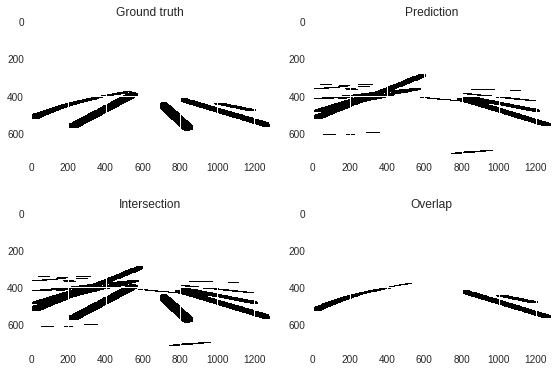

In [288]:
box_diag=50

plt.subplot(221)
gt_lane_i = 5
gt_boxes = boxes_from_gtlanes(lanes,
                              method='bezier',
                              box_diag=box_diag)
gt_box_2d = boxes_to_bool2d(gt_boxes,r,c,method='add')
plt.imshow(gt_box_2d)
plt.title('Ground truth')

pred_boxes = lines_to_boxes(lines,method='bezier',box_diag=box_diag)
pred_box_2d = boxes_to_bool2d(pred_boxes,r,c,method='add')
plt.subplot(222)
plt.imshow(pred_box_2d)
plt.title('Prediction')

intersection = np.logical_or(gt_box_2d,pred_box_2d)

plt.subplot(223)
plt.imshow(intersection)
plt.title('Intersection')

plt.subplot(224)
overlap = np.logical_and(gt_box_2d,pred_box_2d)
plt.imshow(overlap)
plt.title('Overlap')

plt.tight_layout()



In [289]:
  intersection = np.logical_or(gt_box_2d,pred_box_2d)
  overlap = np.logical_and(gt_box_2d,pred_box_2d)
  overlap.sum() / intersection.sum()

0.2822281276820151

Some lanes (not shown) are very curved and are detected piece wise. The picture wide IoU method is robust to this since overlapping predicted lines are treated with an `or` operator.  

# Tune parameters
With the IoU evaluation metric I can investigate how robust parameters are, and which parameter value maximizes the IoU.

In [0]:
gt_boxes = boxes_from_gtlanes(lanes,method='bezier',box_diag=box_diag)
gt_box_2d = boxes_to_bool2d(gt_boxes,r,c,method='add')

In [0]:
def comp_iou_from_lines(gt_box_2d,lines,box_diag):
  try:
    pred_boxes = lines_to_boxes(lines,method='bezier',box_diag=box_diag)
    pred_box_2d = boxes_to_bool2d(pred_boxes,r,c,method='add')
    intersection = np.logical_or(gt_box_2d,pred_box_2d)
    overlap = np.logical_and(gt_box_2d,pred_box_2d)
    iou = overlap.sum() / intersection.sum()
    return(iou)
  except Exception as e:
    print(e,'. ',lines)
    return(np.nan)

Text(0, 0.5, 'Image-wide IoU')

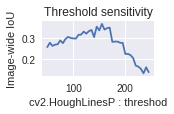

In [308]:
n_lines=[]
thresholds = np.arange(50,250,5)
for threshold in thresholds:
  lines = cv2.HoughLinesP(image=edges,
                        rho=1, # 1 or 2. artefacts appearing for 3,4
                        theta=np.pi/180.,
                        threshold=threshold,
                        minLineLength=75,
                        maxLineGap=50 # not linking edges of same think line
                       )
  if lines is None: lines=[]
  n_lines.append(lines)
sr = pd.Series([comp_iou_from_lines(gt_box_2d,lines,box_diag=50) 
                for lines in n_lines])
sr.index = thresholds


plt.figure(figsize=(2,1))
sr.plot(title='Threshold sensitivity')
plt.xlabel('cv2.HoughLinesP : threshod')
plt.ylabel('Image-wide IoU')

  
  

Text(0, 0.5, 'Image-wide IoU')

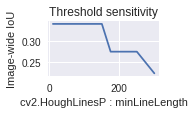

In [296]:
n_lines=[]
minLineLengths = np.append(np.arange(10,100,10),
                           np.array([125,150,175,200,250,300]))
for minLineLength in minLineLengths:
  lines = cv2.HoughLinesP(image=edges,
                        rho=1, # 1 or 2. artefacts appearing for 3,4
                        theta=np.pi/180.,
                        threshold=160,
                        minLineLength=minLineLength,
                        maxLineGap=50 # not linking edges of same think line
                       )
  if lines is None: lines=[]
  n_lines.append(lines)
sr = pd.Series([comp_iou_from_lines(gt_box_2d,lines,box_diag=50) 
                for lines in n_lines])
sr.index = minLineLengths


plt.figure(figsize=(2,1))
sr.plot(title='Threshold sensitivity')
plt.xlabel('cv2.HoughLinesP : minLineLength')
plt.ylabel('Image-wide IoU')

  

Text(0, 0.5, 'Image-wide IoU')

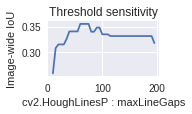

In [310]:
n_lines=[]
maxLineGaps = np.arange(10,200,5)
for maxLineGap in maxLineGaps:
  lines = cv2.HoughLinesP(image=edges,
                        rho=1, 
                        theta=np.pi/180.,
                        threshold=160,
                        minLineLength=75,
                        maxLineGap=maxLineGap 
                       )
  if lines is None: lines=[]
  n_lines.append(lines)
sr = pd.Series([comp_iou_from_lines(gt_box_2d,lines,box_diag=50) 
                for lines in n_lines])
sr.index = maxLineGaps


plt.figure(figsize=(2,1))
sr.plot(title='Threshold sensitivity')
plt.xlabel('cv2.HoughLinesP : maxLineGaps')
plt.ylabel('Image-wide IoU')

  

Text(0, 0.5, 'Image-wide IoU')

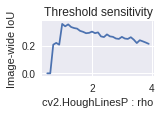

In [309]:
n_lines=[]
rhos = np.arange(0.5,4,0.1)
for rho in rhos:
  lines = cv2.HoughLinesP(image=edges,
                        rho=rho, 
                        theta=np.pi/180.,
                        threshold=160,
                        minLineLength=75,
                        maxLineGap=60 
                       )
  if lines is None: lines=[]
  n_lines.append(lines)
sr = pd.Series([comp_iou_from_lines(gt_box_2d,lines,box_diag=50) 
                for lines in n_lines])
sr.index = rhos


plt.figure(figsize=(2,1))
sr.plot(title='Threshold sensitivity')
plt.xlabel('cv2.HoughLinesP : rho')
plt.ylabel('Image-wide IoU')

Text(0, 0.5, 'Image-wide IoU')

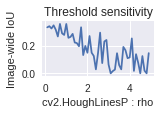

In [305]:
n_lines=[]
thetas = np.arange(0.1,5,0.1)
for theta in thetas:
  lines = cv2.HoughLinesP(image=edges,
                        rho=1, 
                        theta=theta*np.pi/180.,
                        threshold=160,
                        minLineLength=75,
                        maxLineGap=60 
                       )
  if lines is None: lines=[]
  n_lines.append(lines)
  
  sr = pd.Series([comp_iou_from_lines(gt_box_2d,lines,box_diag=50) 
                for lines in n_lines])
sr.index = thetas


plt.figure(figsize=(2,1))
sr.plot(title='Threshold sensitivity')
plt.xlabel('cv2.HoughLinesP : rho')
plt.ylabel('Image-wide IoU')

We have clear optimal parameter values of: 
1. `rho` 0.8-1.2
2. `theta` 0.5-1
2. `maxLineGaps` 60-80
3. `minLineLength` 50-150
4. `threshold` 125-160



# Conclusion

I tuned the Hough parameters for one example image. We can use these to further tune parameters for many images in a batch manner. Some images (not shown) have unmarked lanes, but are annotated as a lane from the nearby cars. This method is unsuitable for them.

Further heuristics can be layered on top of this method such as
1. excluding regions (dash board, detected objects)
2. expected values of the Hough transform can be excluded (eg vertical lines in the upper part of the image from poles and buildings)

If we consider the line detection process in two steps (Canny edge detection, hough line transformation), we could also investigate the Canny thresholds by IoU. We will do this in the third and last notebook. 

Further research could leverages the temporal correlation of frames. For instance, in [conference proceedings](https://www.researchgate.net/publication/221126736_Robust_lane_detection_and_tracking_with_Ransac_and_Kalman_filter) for International Conference on Image Processing in 2009, one group improved a similar method to the one I implemented (Edge detection with Hough transform) with a Kalman filter, which can handle how the frames are temporally correlated, but with noise caused by vibrations such as bumps in the road.

